# Music Genre Classification: LSTM vs RNN Comparison
## with Confusion Matrix Analysis

In [1]:
import os
import random
from glob import glob
from typing import List, Tuple

import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

# For confusion matrix and metrics
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

Using device: mps


## Data Setup

In [2]:
DATA_ROOT = "/Users/artemsotnikov/PycharmProjects/Lesson_41)/Lesson_43/Data/"
AUDIO_ROOT = os.path.join(DATA_ROOT, "genres_original")

# Collect all files
classes = sorted([d for d in os.listdir(AUDIO_ROOT) if os.path.isdir(os.path.join(AUDIO_ROOT, d))])
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

all_files = []
for c in classes:
    files = glob(os.path.join(AUDIO_ROOT, c, "*.wav"))
    all_files += [(f, class_to_idx[c]) for f in files]

random.shuffle(all_files)

VAL_SPLIT = 0.2
val_size = int(len(all_files) * VAL_SPLIT)
val_files = all_files[:val_size]
train_files = all_files[val_size:]

# Audio params
SAMPLE_RATE = 22050
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
MAX_SECONDS = 30

# Training params
BATCH_SIZE = 16
EPOCHS = 70
LR = 1e-3
NUM_CLASSES = 10

MAX_SAMPLES = SAMPLE_RATE * MAX_SECONDS
MIXUP_ALPHA = 0.0
LABEL_SMOOTHING = 0.0

BEST_MODEL_PATH_LSTM = "best_model_lstm.pt"
BEST_MODEL_PATH_RNN = "best_model_rnn.pt"

print(f"Classes: {classes}")
print(f"Train samples: {len(train_files)}, Val samples: {len(val_files)}")

Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Train samples: 800, Val samples: 199


In [3]:
import soundfile as sf

def is_readable(path):
    try:
        _ = sf.info(path)
        return True
    except Exception:
        return False

all_files = [(f, label) for (f, label) in all_files if is_readable(f)]
print("Readable files:", len(all_files))

# Re-split after filtering
random.shuffle(all_files)
val_size = int(len(all_files) * VAL_SPLIT)
val_files = all_files[:val_size]
train_files = all_files[val_size:]

Readable files: 999


## Dataset Definition

In [4]:
class GTZANDataset(Dataset):
    def __init__(self, files, sample_rate=22050, n_mels=128, n_fft=2048, hop_length=512,
                 window_seconds=3, mode="train", num_val_crops=5,
                 freq_mask=8, time_mask=20, gain_min=0.9, gain_max=1.1,
                 aug_prob=0.5, time_shift_pct=0.1, noise_std=0.005):
        self.files = files
        self.sample_rate = sample_rate
        self.window_samples = sample_rate * window_seconds
        self.mode = mode
        self.num_val_crops = num_val_crops
        self.do_augment = (mode == "train")
        self.gain_min = gain_min
        self.gain_max = gain_max
        self.aug_prob = aug_prob
        self.time_shift_pct = time_shift_pct
        self.noise_std = noise_std

        self.mel = MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )
        self.db = AmplitudeToDB(stype="power")

        self.freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask)
        self.time_mask = torchaudio.transforms.TimeMasking(time_mask_param=time_mask)

    def __len__(self):
        return len(self.files)

    def _load_audio(self, path):
        import soundfile as sf
        try:
            wav, sr = sf.read(path, dtype="float32", always_2d=True)
        except Exception:
            return None

        wav = wav.T
        if wav.shape[0] > 1:
            wav = wav.mean(axis=0, keepdims=True)
        
        wav = torch.from_numpy(wav)

        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            wav = resampler(wav)

        return wav

    def _augment(self, wav):
        if random.random() < self.aug_prob:
            gain = random.uniform(self.gain_min, self.gain_max)
            wav = wav * gain

        if random.random() < self.aug_prob:
            shift = int(wav.size(1) * self.time_shift_pct * (random.random() - 0.5))
            wav = torch.roll(wav, shifts=shift, dims=1)

        if random.random() < self.aug_prob:
            noise = torch.randn_like(wav) * self.noise_std
            wav = wav + noise

        return wav

    def __getitem__(self, idx):
        path, label = self.files[idx]
        wav = self._load_audio(path)
        
        if wav is None:
            return self.__getitem__((idx + 1) % len(self.files))

        if self.mode == "train":
            if wav.size(1) < self.window_samples:
                pad = self.window_samples - wav.size(1)
                wav = F.pad(wav, (0, pad))
            
            max_start = wav.size(1) - self.window_samples
            start = random.randint(0, max_start) if max_start > 0 else 0
            wav = wav[:, start:start+self.window_samples]

            if self.do_augment:
                wav = self._augment(wav)

            mel = self.mel(wav)
            mel = self.db(mel)

            if self.do_augment:
                mel = self.freq_mask(mel)
                mel = self.time_mask(mel)

            return mel, label
        else:
            crops = []
            total = wav.size(1)
            
            if total < self.window_samples:
                pad = self.window_samples - total
                wav = F.pad(wav, (0, pad))
                crops.append(wav)
            else:
                step = (total - self.window_samples) / max(1, self.num_val_crops - 1)
                for i in range(self.num_val_crops):
                    start = int(i * step)
                    end = start + self.window_samples
                    crops.append(wav[:, start:end])

            mels = []
            for crop in crops:
                mel = self.mel(crop)
                mel = self.db(mel)
                mels.append(mel)

            mels = torch.stack(mels, dim=0)
            return mels, label

## Model Definitions

In [5]:
class CNNBiLSTMAttention(nn.Module):
    """Original model with BiLSTM"""
    def __init__(self, n_mels=128, num_classes=10, hidden=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout2d = nn.Dropout2d(dropout)
        
        freq_dim = n_mels // (2**3)
        self.lstm_input = 128 * freq_dim
        
        self.lstm = nn.LSTM(
            input_size=self.lstm_input,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.attention = nn.Linear(hidden * 2, 1)
        self.fc = nn.Linear(hidden * 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout2d(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2d(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout2d(x)
        
        B, C, H, W = x.shape
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(B, W, C * H)
        
        lstm_out, _ = self.lstm(x)
        
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = (lstm_out * attn_weights).sum(dim=1)
        
        context = self.dropout(context)
        logits = self.fc(context)
        
        return logits, attn_weights


class CNNBiRNNAttention(nn.Module):
    """Model with simple BiRNN instead of BiLSTM"""
    def __init__(self, n_mels=128, num_classes=10, hidden=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout2d = nn.Dropout2d(dropout)
        
        freq_dim = n_mels // (2**3)
        self.rnn_input = 128 * freq_dim
        
        # Simple RNN instead of LSTM
        self.rnn = nn.RNN(
            input_size=self.rnn_input,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.attention = nn.Linear(hidden * 2, 1)
        self.fc = nn.Linear(hidden * 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout2d(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2d(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout2d(x)
        
        B, C, H, W = x.shape
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(B, W, C * H)
        
        rnn_out, _ = self.rnn(x)
        
        attn_weights = torch.softmax(self.attention(rnn_out), dim=1)
        context = (rnn_out * attn_weights).sum(dim=1)
        
        context = self.dropout(context)
        logits = self.fc(context)
        
        return logits, attn_weights

## Create Datasets

In [6]:
train_ds = GTZANDataset(train_files, sample_rate=SAMPLE_RATE, n_mels=N_MELS,
                        n_fft=N_FFT, hop_length=HOP_LENGTH,
                        window_seconds=3, mode="train",
                        freq_mask=8, time_mask=20, gain_min=0.9, gain_max=1.1,
                        aug_prob=0.5, time_shift_pct=0.1, noise_std=0.005)

val_ds = GTZANDataset(val_files, sample_rate=SAMPLE_RATE, n_mels=N_MELS,
                      n_fft=N_FFT, hop_length=HOP_LENGTH,
                      window_seconds=3, mode="val", num_val_crops=5)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

print(f"Train dataset size: {len(train_ds)}")
print(f"Val dataset size: {len(val_ds)}")

Train dataset size: 800
Val dataset size: 199


## Training and Evaluation Functions

In [7]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            B, C, _, _, _ = x.shape
            x = x.view(B * C, 1, x.size(3), x.size(4)).to(device)
            y = y.to(device)

            logits, _ = model(x)
            logits = logits.view(B, C, -1).mean(dim=1)

            loss = criterion(logits, y)
            total_loss += loss.item() * B

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += B

    return total_loss / total, correct / total


def get_predictions(model, loader):
    """Get all predictions and true labels for confusion matrix"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            B, C, _, _, _ = x.shape
            x = x.view(B * C, 1, x.size(3), x.size(4)).to(device)
            y = y.to(device)

            logits, _ = model(x)
            logits = logits.view(B, C, -1).mean(dim=1)

            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

## Confusion Matrix Plotting Function

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes, title, figsize=(12, 10)):
    """Plot confusion matrix with percentages"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, ax=ax1)
    ax1.set_title(f'{title} - Counts')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # Percentages
    sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Greens',
                xticklabels=classes, yticklabels=classes, ax=ax2)
    ax2.set_title(f'{title} - Percentages (%)')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    return fig, cm, cm_normalized

## Train BiLSTM Model

In [9]:
print("="*80)
print("TRAINING BiLSTM MODEL")
print("="*80)

model_lstm = CNNBiLSTMAttention(n_mels=N_MELS, num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=LR, weight_decay=1e-4)
scheduler_lstm = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_lstm, mode="max", patience=3, factor=0.5)

best_acc_lstm = 0.0
patience = 8
patience_left = patience

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model_lstm, train_loader, optimizer_lstm, criterion)
    val_loss, val_acc = validate(model_lstm, val_loader, criterion)
    scheduler_lstm.step(val_acc)

    if val_acc > best_acc_lstm:
        best_acc_lstm = val_acc
        patience_left = patience
        torch.save(model_lstm.state_dict(), BEST_MODEL_PATH_LSTM)
    else:
        patience_left -= 1

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Best: {best_acc_lstm:.4f}")

    if patience_left == 0:
        print("Early stopping")
        break

print(f"\nBest BiLSTM validation accuracy: {best_acc_lstm:.4f}")

TRAINING BiLSTM MODEL
Epoch 01 | Train Loss: 2.1831, Train Acc: 0.1713 | Val Loss: 1.9969, Val Acc: 0.2412 | Best: 0.2412
Epoch 02 | Train Loss: 2.0010, Train Acc: 0.2625 | Val Loss: 1.7723, Val Acc: 0.3719 | Best: 0.3719
Epoch 03 | Train Loss: 1.9242, Train Acc: 0.3075 | Val Loss: 1.7069, Val Acc: 0.4070 | Best: 0.4070
Epoch 04 | Train Loss: 1.7855, Train Acc: 0.3412 | Val Loss: 1.5707, Val Acc: 0.4523 | Best: 0.4523
Epoch 05 | Train Loss: 1.7544, Train Acc: 0.3350 | Val Loss: 1.5376, Val Acc: 0.5176 | Best: 0.5176
Epoch 06 | Train Loss: 1.7123, Train Acc: 0.3787 | Val Loss: 1.5534, Val Acc: 0.4673 | Best: 0.5176
Epoch 07 | Train Loss: 1.6273, Train Acc: 0.3900 | Val Loss: 1.4541, Val Acc: 0.4422 | Best: 0.5176
Epoch 08 | Train Loss: 1.6397, Train Acc: 0.3887 | Val Loss: 1.3852, Val Acc: 0.5427 | Best: 0.5427
Epoch 09 | Train Loss: 1.5761, Train Acc: 0.4213 | Val Loss: 1.3356, Val Acc: 0.5930 | Best: 0.5930
Epoch 10 | Train Loss: 1.5663, Train Acc: 0.4375 | Val Loss: 1.4483, Val Acc: 

## BiLSTM Confusion Matrix

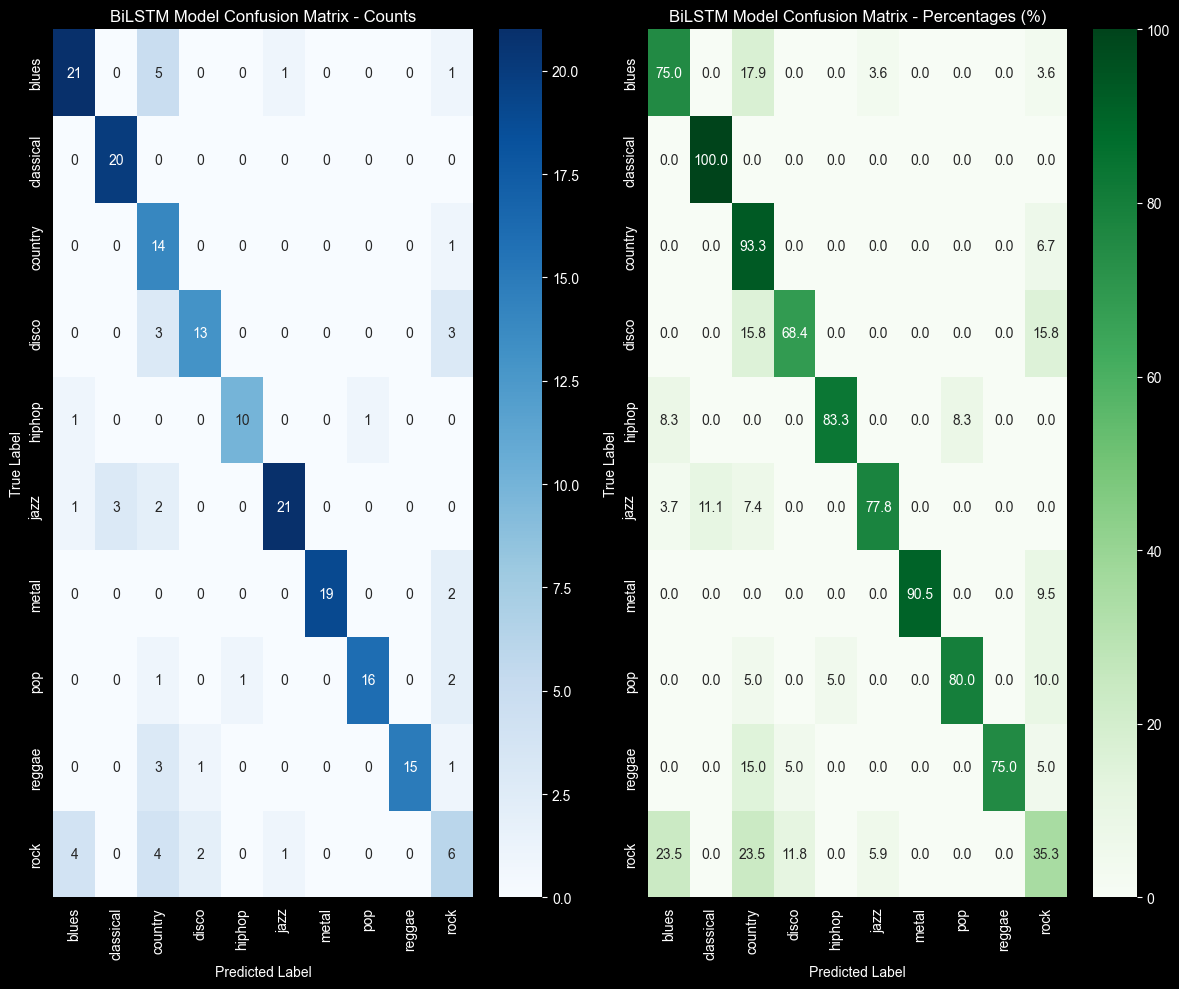


BiLSTM Classification Report:
              precision    recall  f1-score   support

       blues       0.78      0.75      0.76        28
   classical       0.87      1.00      0.93        20
     country       0.44      0.93      0.60        15
       disco       0.81      0.68      0.74        19
      hiphop       0.91      0.83      0.87        12
        jazz       0.91      0.78      0.84        27
       metal       1.00      0.90      0.95        21
         pop       0.94      0.80      0.86        20
      reggae       1.00      0.75      0.86        20
        rock       0.38      0.35      0.36        17

    accuracy                           0.78       199
   macro avg       0.80      0.78      0.78       199
weighted avg       0.82      0.78      0.79       199



In [10]:
# Load best LSTM model
model_lstm.load_state_dict(torch.load(BEST_MODEL_PATH_LSTM))
model_lstm.eval()

# Get predictions
y_true_lstm, y_pred_lstm = get_predictions(model_lstm, val_loader)

# Plot confusion matrix
fig_lstm, cm_lstm, cm_norm_lstm = plot_confusion_matrix(
    y_true_lstm, y_pred_lstm, classes, 
    title="BiLSTM Model Confusion Matrix"
)
plt.savefig('/Users/artemsotnikov/PycharmProjects/Lesson_41)/Lesson_43/confusion_matrix_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nBiLSTM Classification Report:")
print(classification_report(y_true_lstm, y_pred_lstm, target_names=classes))

## Train BiRNN Model

In [11]:
print("\n" + "="*80)
print("TRAINING BiRNN MODEL")
print("="*80)

model_rnn = CNNBiRNNAttention(n_mels=N_MELS, num_classes=NUM_CLASSES).to(device)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=LR, weight_decay=1e-4)
scheduler_rnn = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_rnn, mode="max", patience=3, factor=0.5)

best_acc_rnn = 0.0
patience_left = patience

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model_rnn, train_loader, optimizer_rnn, criterion)
    val_loss, val_acc = validate(model_rnn, val_loader, criterion)
    scheduler_rnn.step(val_acc)

    if val_acc > best_acc_rnn:
        best_acc_rnn = val_acc
        patience_left = patience
        torch.save(model_rnn.state_dict(), BEST_MODEL_PATH_RNN)
    else:
        patience_left -= 1

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Best: {best_acc_rnn:.4f}")

    if patience_left == 0:
        print("Early stopping")
        break

print(f"\nBest BiRNN validation accuracy: {best_acc_rnn:.4f}")


TRAINING BiRNN MODEL
Epoch 01 | Train Loss: 2.3236, Train Acc: 0.1737 | Val Loss: 2.0129, Val Acc: 0.1859 | Best: 0.1859
Epoch 02 | Train Loss: 2.0456, Train Acc: 0.2575 | Val Loss: 1.6811, Val Acc: 0.4020 | Best: 0.4020
Epoch 03 | Train Loss: 1.8779, Train Acc: 0.3400 | Val Loss: 1.5921, Val Acc: 0.4322 | Best: 0.4322
Epoch 04 | Train Loss: 1.8002, Train Acc: 0.3750 | Val Loss: 1.5170, Val Acc: 0.5226 | Best: 0.5226
Epoch 05 | Train Loss: 1.7475, Train Acc: 0.3875 | Val Loss: 1.3051, Val Acc: 0.5276 | Best: 0.5276
Epoch 06 | Train Loss: 1.6802, Train Acc: 0.3975 | Val Loss: 1.3197, Val Acc: 0.4975 | Best: 0.5276
Epoch 07 | Train Loss: 1.7125, Train Acc: 0.3950 | Val Loss: 1.4199, Val Acc: 0.5226 | Best: 0.5276
Epoch 08 | Train Loss: 1.6411, Train Acc: 0.3925 | Val Loss: 1.3101, Val Acc: 0.4925 | Best: 0.5276
Epoch 09 | Train Loss: 1.5740, Train Acc: 0.4425 | Val Loss: 1.2352, Val Acc: 0.5879 | Best: 0.5879
Epoch 10 | Train Loss: 1.6055, Train Acc: 0.4250 | Val Loss: 1.2525, Val Acc: 

## BiRNN Confusion Matrix

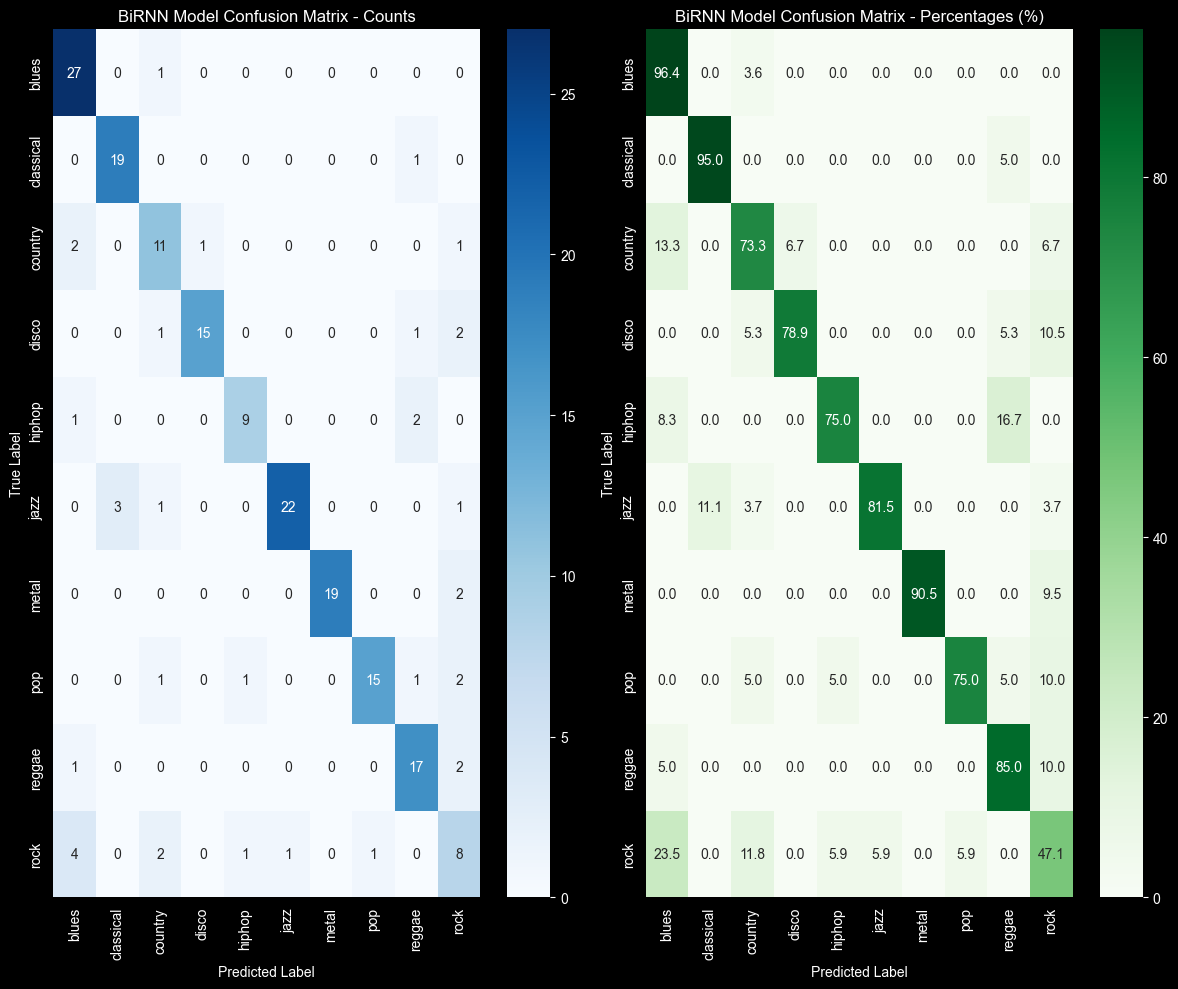


BiRNN Classification Report:
              precision    recall  f1-score   support

       blues       0.77      0.96      0.86        28
   classical       0.86      0.95      0.90        20
     country       0.65      0.73      0.69        15
       disco       0.94      0.79      0.86        19
      hiphop       0.82      0.75      0.78        12
        jazz       0.96      0.81      0.88        27
       metal       1.00      0.90      0.95        21
         pop       0.94      0.75      0.83        20
      reggae       0.77      0.85      0.81        20
        rock       0.44      0.47      0.46        17

    accuracy                           0.81       199
   macro avg       0.81      0.80      0.80       199
weighted avg       0.83      0.81      0.82       199



In [12]:
# Load best RNN model
model_rnn.load_state_dict(torch.load(BEST_MODEL_PATH_RNN))
model_rnn.eval()

# Get predictions
y_true_rnn, y_pred_rnn = get_predictions(model_rnn, val_loader)

# Plot confusion matrix
fig_rnn, cm_rnn, cm_norm_rnn = plot_confusion_matrix(
    y_true_rnn, y_pred_rnn, classes, 
    title="BiRNN Model Confusion Matrix"
)
plt.savefig('/Users/artemsotnikov/PycharmProjects/Lesson_41)/Lesson_43/confusion_matrix_rnn.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nBiRNN Classification Report:")
print(classification_report(y_true_rnn, y_pred_rnn, target_names=classes))

## Comparison Analysis

In [13]:
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

# Overall accuracy
lstm_acc = (y_true_lstm == y_pred_lstm).mean()
rnn_acc = (y_true_rnn == y_pred_rnn).mean()

print(f"\nOverall Accuracy:")
print(f"  BiLSTM: {lstm_acc:.4f} ({lstm_acc*100:.2f}%)")
print(f"  BiRNN:  {rnn_acc:.4f} ({rnn_acc*100:.2f}%)")
print(f"  Difference: {abs(lstm_acc - rnn_acc):.4f} ({abs(lstm_acc - rnn_acc)*100:.2f}%)")

if lstm_acc > rnn_acc:
    print(f"  Winner: BiLSTM by {(lstm_acc - rnn_acc)*100:.2f}%")
else:
    print(f"  Winner: BiRNN by {(rnn_acc - lstm_acc)*100:.2f}%")

# Per-class accuracy
print("\nPer-class Accuracy Comparison:")
print(f"{'Class':<15} {'BiLSTM':<10} {'BiRNN':<10} {'Difference':<10}")
print("-" * 50)

for i, class_name in enumerate(classes):
    lstm_class_acc = cm_norm_lstm[i, i]
    rnn_class_acc = cm_norm_rnn[i, i]
    diff = lstm_class_acc - rnn_class_acc
    
    print(f"{class_name:<15} {lstm_class_acc:>6.2f}%   {rnn_class_acc:>6.2f}%   {diff:>+6.2f}%")

# Model parameters
lstm_params = sum(p.numel() for p in model_lstm.parameters())
rnn_params = sum(p.numel() for p in model_rnn.parameters())

print(f"\nModel Parameters:")
print(f"  BiLSTM: {lstm_params:,}")
print(f"  BiRNN:  {rnn_params:,}")
print(f"  Difference: {abs(lstm_params - rnn_params):,} ({abs(lstm_params - rnn_params)/lstm_params*100:.1f}%)")


MODEL COMPARISON

Overall Accuracy:
  BiLSTM: 0.7789 (77.89%)
  BiRNN:  0.8141 (81.41%)
  Difference: 0.0352 (3.52%)
  Winner: BiRNN by 3.52%

Per-class Accuracy Comparison:
Class           BiLSTM     BiRNN      Difference
--------------------------------------------------
blues            75.00%    96.43%   -21.43%
classical       100.00%    95.00%    +5.00%
country          93.33%    73.33%   +20.00%
disco            68.42%    78.95%   -10.53%
hiphop           83.33%    75.00%    +8.33%
jazz             77.78%    81.48%    -3.70%
metal            90.48%    90.48%    +0.00%
pop              80.00%    75.00%    +5.00%
reggae           75.00%    85.00%   -10.00%
rock             35.29%    47.06%   -11.76%

Model Parameters:
  BiLSTM: 6,398,411
  BiRNN:  1,673,675
  Difference: 4,724,736 (73.8%)


## Side-by-Side Comparison Plot

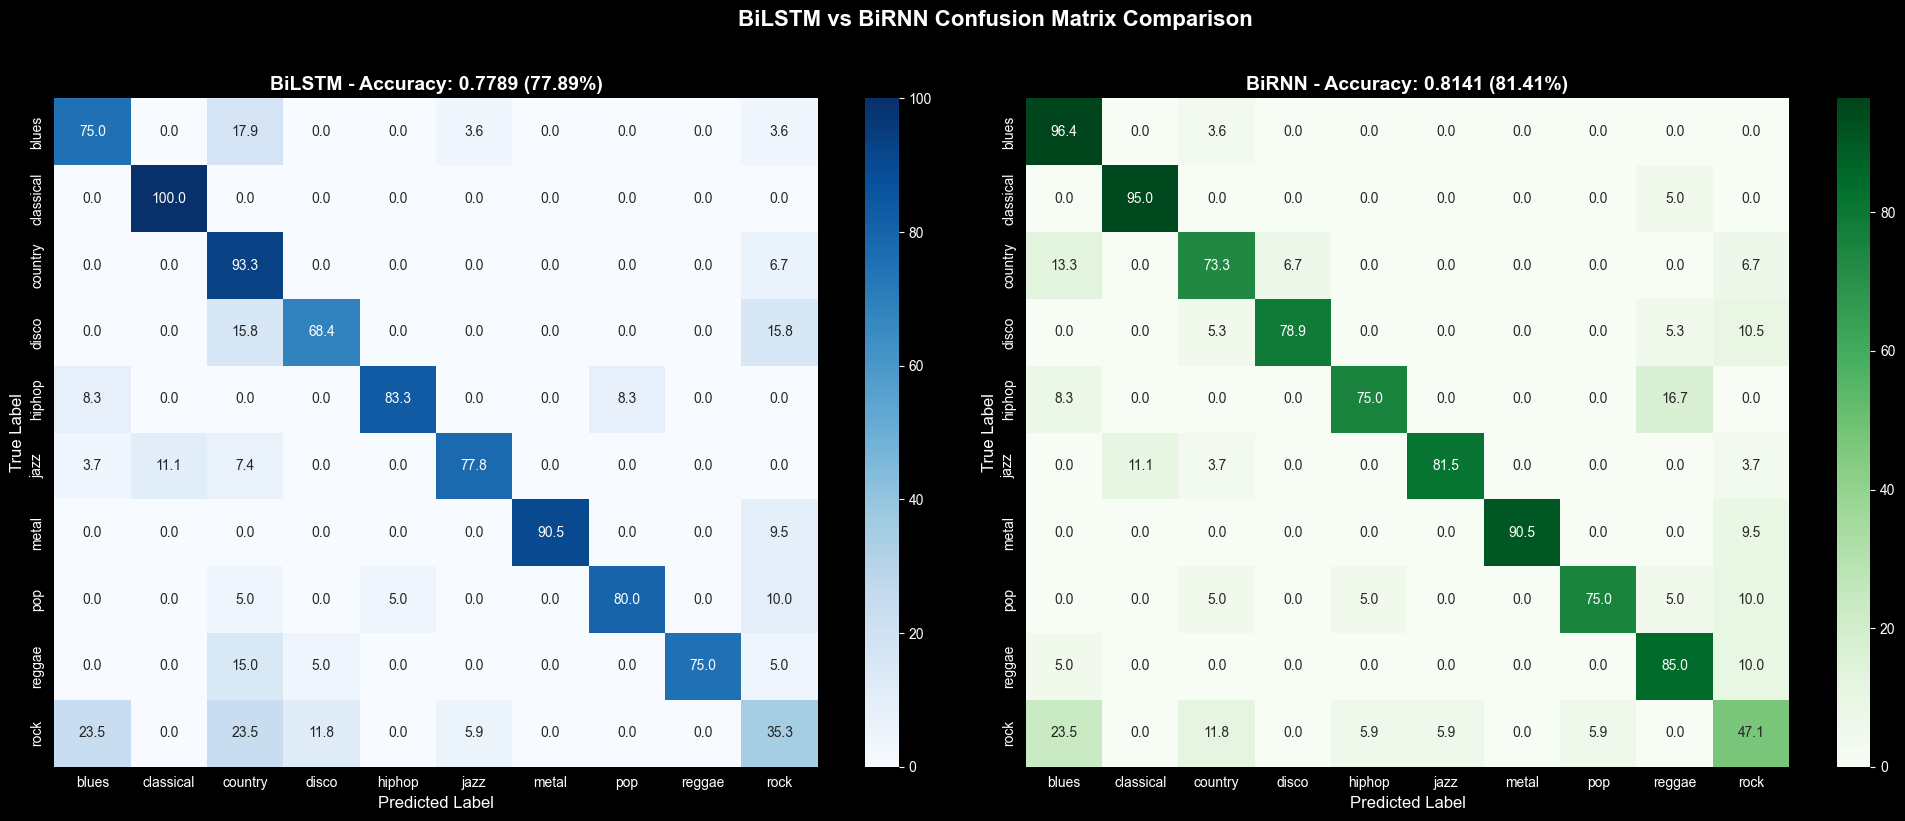

In [14]:
# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# BiLSTM
sns.heatmap(cm_norm_lstm, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title(f'BiLSTM - Accuracy: {lstm_acc:.4f} ({lstm_acc*100:.2f}%)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# BiRNN
sns.heatmap(cm_norm_rnn, annot=True, fmt='.1f', cmap='Greens',
            xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title(f'BiRNN - Accuracy: {rnn_acc:.4f} ({rnn_acc*100:.2f}%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.suptitle('BiLSTM vs BiRNN Confusion Matrix Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/Users/artemsotnikov/PycharmProjects/Lesson_41)/Lesson_43/comparison_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## Per-Class Performance Comparison

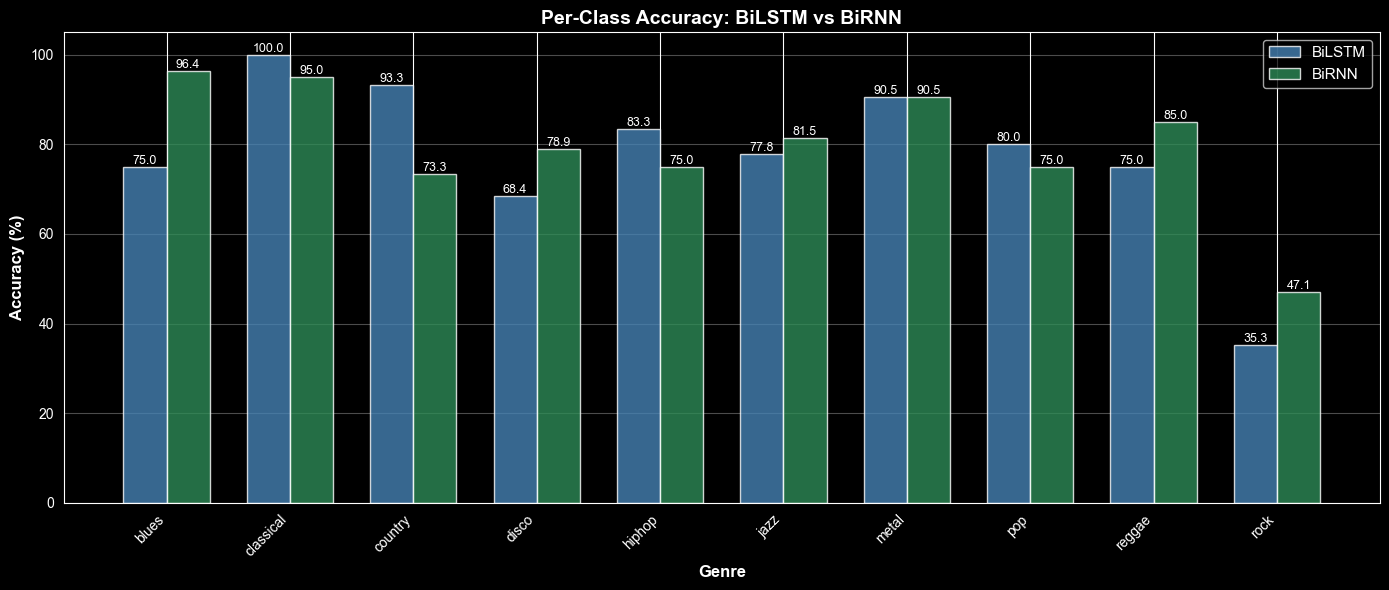

In [15]:
# Bar plot comparing per-class accuracy
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(classes))
width = 0.35

lstm_accuracies = [cm_norm_lstm[i, i] for i in range(len(classes))]
rnn_accuracies = [cm_norm_rnn[i, i] for i in range(len(classes))]

bars1 = ax.bar(x - width/2, lstm_accuracies, width, label='BiLSTM', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, rnn_accuracies, width, label='BiRNN', color='seagreen', alpha=0.8)

ax.set_xlabel('Genre', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Accuracy: BiLSTM vs BiRNN', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/Users/artemsotnikov/PycharmProjects/Lesson_41)/Lesson_43/per_class_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary and Conclusions

In [16]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

print("\nKey Findings:")
print(f"1. Overall Performance:")
print(f"   - BiLSTM achieved {lstm_acc*100:.2f}% accuracy")
print(f"   - BiRNN achieved {rnn_acc*100:.2f}% accuracy")

print(f"\n2. Model Complexity:")
print(f"   - BiLSTM has {lstm_params:,} parameters")
print(f"   - BiRNN has {rnn_params:,} parameters")
print(f"   - Parameter reduction: {(1 - rnn_params/lstm_params)*100:.1f}%")

print(f"\n3. Best Performing Classes:")
lstm_best_idx = np.argmax([cm_norm_lstm[i, i] for i in range(len(classes))])
rnn_best_idx = np.argmax([cm_norm_rnn[i, i] for i in range(len(classes))])
print(f"   - BiLSTM: {classes[lstm_best_idx]} ({cm_norm_lstm[lstm_best_idx, lstm_best_idx]:.2f}%)")
print(f"   - BiRNN: {classes[rnn_best_idx]} ({cm_norm_rnn[rnn_best_idx, rnn_best_idx]:.2f}%)")

print(f"\n4. Worst Performing Classes:")
lstm_worst_idx = np.argmin([cm_norm_lstm[i, i] for i in range(len(classes))])
rnn_worst_idx = np.argmin([cm_norm_rnn[i, i] for i in range(len(classes))])
print(f"   - BiLSTM: {classes[lstm_worst_idx]} ({cm_norm_lstm[lstm_worst_idx, lstm_worst_idx]:.2f}%)")
print(f"   - BiRNN: {classes[rnn_worst_idx]} ({cm_norm_rnn[rnn_worst_idx, rnn_worst_idx]:.2f}%)")

print("\n" + "="*80)
print("Analysis complete! All confusion matrices and comparison plots have been saved.")
print("="*80)


SUMMARY

Key Findings:
1. Overall Performance:
   - BiLSTM achieved 77.89% accuracy
   - BiRNN achieved 81.41% accuracy

2. Model Complexity:
   - BiLSTM has 6,398,411 parameters
   - BiRNN has 1,673,675 parameters
   - Parameter reduction: 73.8%

3. Best Performing Classes:
   - BiLSTM: classical (100.00%)
   - BiRNN: blues (96.43%)

4. Worst Performing Classes:
   - BiLSTM: rock (35.29%)
   - BiRNN: rock (47.06%)

Analysis complete! All confusion matrices and comparison plots have been saved.
